# Credit Risk

Context: The provided dataset contains information on credit risk generated by an international bank operating in Argentina. This data has been transformed and enriched to reflect various customer situations and payment behaviors that could affect the accuracy of risk prediction models. The task consists of identifying and analyzing potential biases in key variables within the dataset—such as customer age, loan amount, and employment type—using descriptive statistics, hypothesis testing, and visualizations.



In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("credit_risk.csv")

In [3]:
df.head()

,Unnamed: 0,incumplimiento,tipo_de_cuenta,genero,edad_del_cliente,co_solicitantes,dependientes,monto_del_prestamo,ubicacion_de_sucursal,nivel_de_producto,estatus_laboral,es_sostenedor_principal,grupo_de_puntaje_crediticio,area_residencial,estado_actual_de_la_cuenta,tiene_cuenta_conjunta,indicador_aleatorio,residencial_Rural,residencial_Suburbana,residencial_Urbana
0,0,1.0,3,male,26.618129,1,0,7.2500,Suburbana,Third,man,True,NaN,Urbana,no,0,0.949435,0.0,0.0,1.0
1,1,1.0,3,female,27.395476,1,0,71.2833,Central,First,woman,False,C,Urbana,yes,0,0.015243,0.0,0.0,1.0
2,2,1.0,1,female,48.696543,0,0,7.9250,Suburbana,Third,woman,False,NaN,Rural,yes,1,0.672372,1.0,0.0,0.0
3,3,1.0,3,female,25.491890,1,0,53.1000,Suburbana,First,woman,False,C,Urbana,yes,0,0.403598,0.0,0.0,1.0
4,4,0.0,1,male,41.038217,0,0,8.0500,Suburbana,Third,man,True,NaN,Suburbana,no,1,0.852901,0.0,1.0,0.0


In [4]:
df.shape

(1906, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1906 non-null   int64  
 1   incumplimiento               1906 non-null   float64
 2   tipo_de_cuenta               1906 non-null   object 
 3   genero                       1906 non-null   object 
 4   edad_del_cliente             1906 non-null   float64
 5   co_solicitantes              1906 non-null   int64  
 6   dependientes                 1906 non-null   int64  
 7   monto_del_prestamo           1906 non-null   float64
 8   ubicacion_de_sucursal        1904 non-null   object 
 9   nivel_de_producto            1906 non-null   object 
 10  estatus_laboral              1906 non-null   object 
 11  es_sostenedor_principal      1906 non-null   bool   
 12  grupo_de_puntaje_crediticio  1215 non-null   object 
 13  area_residencial  

There are columns of different types: bool(1), float64(7), int64(3), object(9).

residencial_Rural, residencial_Suburbana, and residencial_Urbana have the highest number of null values (1014). If these are NaNs because a value of 0 should go there, I can replace them and keep them as binary variables—but only if I’m going to use them in my analysis; otherwise, it’s unnecessary.

The customer’s age is in float64. It shouldn’t have decimals, so I need to convert it to int.

The prompt mentions it’s an international bank and the dataset is from Argentina, so I should check the area_residencial variable.

Values taken by the target variable: in this case, '0 = compliant' and '1 = non-compliant'

In [15]:
df.incumplimiento.unique()  

array([1., 0.])

I remove the columns that are not useful: 'Unnamed: 0' and 'indicador_aleatorio'

In [7]:
df.drop(columns=["indicador_aleatorio", 'Unnamed: 0'], axis=1, inplace=True) 

Convert customer age to integer format









In [8]:
df["edad_del_cliente"] = df["edad_del_cliente"].astype(int)

### This function allows me to view the values in each column divided based on the result of the 'Incumplimiento' (Non-compliance) column.

In [9]:
def valores_unicos_por_categoria(df, columna):
    # Dividir el DataFrame en dos según la columna de categorías
    valores = df[columna].unique()
    categoria_1 = df[df[columna] == valores[0]]
    categoria_2 = df[df[columna] == valores[1]]

    # Recorrer todas las columnas del DataFrame original
    for col in df.columns:
        if col != columna:  # Evitar la columna de categorías
            print(f"Valores únicos en '{col}' para '{valores[0]}':")
            print(categoria_1[col].unique())

            print(f"Valores únicos en '{col}' para '{valores[1]}':")
            print(categoria_2[col].unique())
            print("-----------------------")

In [10]:
valores_unicos_por_categoria(df, "incumplimiento")

Valores únicos en 'tipo_de_cuenta' para '1.0':
['3' '1' '2']
Valores únicos en 'tipo_de_cuenta' para '0.0':
['1' '3' '2' 'Inversiones' 'Ahorro' 'Corriente']
-----------------------
Valores únicos en 'genero' para '1.0':
['male' 'female']
Valores únicos en 'genero' para '0.0':
['male' 'female' 'Hombre' 'Mujer']
-----------------------
Valores únicos en 'edad_del_cliente' para '1.0':
[26 27 48 25 21 50 45 47 22 49 20 19 46 28 18 31 42 23 30 29 24 32 35 51
 34 44 33 53 43 38 52 36 56 55 40 54 37 58 17 16 13]
Valores únicos en 'edad_del_cliente' para '0.0':
[41 43 48 26 24 45 47 44 52 51 29 30 21 42 46 23 54 18 53 25 31 28 50 33
 55 32 49 27 20 22 38 40 19 39 34 77 81 87 88 80 85 37 82 67 64 69 68 75
 63 56 84 73 76 36 74 86 78 35 89 70 61 65 62 58 71 57 83 66 79 72 59 60]
-----------------------
Valores únicos en 'co_solicitantes' para '1.0':
[1 0 3 2 4 5 8]
Valores únicos en 'co_solicitantes' para '0.0':
[0 4 1 3 2 5 8]
-----------------------
Valores únicos en 'dependientes' para '1.0':

We were able to analyze:
In 'tipo_de_cuenta': the categories 'Inversiones', 'Ahorro', and 'Corriente' do not appear among non-compliant customers.

In unique values for 'genero': ['male', 'female', 'Hombre', 'Mujer'] should be normalized to 'male' and 'female' to keep the data clean.

In 'ubicacion_de_sucursal': 'Quito' appears among both defaulters and non-defaulters, and 'Suiza' appears among compliant customers. These locations do not correspond to an Argentine dataset.

In 'nivel_de_producto': among compliant customers, there’s a different classification: ['Third', 'First', 'Second', 'Básico', 'Avanzado', 'Intermedio']. It’s worth investigating whether these are alternate labels for the same categories.

In 'estatus_laboral': values such as ['man', 'woman', 'child', 'Empleo a tiempo parcial', 'Desempleado', 'Retirado', 'Estudiante', 'Empleo', 'Desempleo'] need cleaning. It's unclear whether it's worth keeping terms like "man", "woman", "child", and inconsistent labels like 'Desempleado' vs 'Desempleo'. The proportion of these values should be reviewed to assess their relevance.

Credit risk categories should be investigated, as the same category may be labeled in different ways. For example, non-compliant customers have labels using letters, while compliant customers include numbers as well.

In 'tiene_cuenta_conjunta': values include 0, 1, true, and false. These might represent the same thing and should be normalized.

For the residential columns, which have values 1, 0, or NaN, NaNs could be converted to 0 (indicating the condition is not met). However, it’s also possible that the data wasn’t filled in or the information is missing.

In 'dependientes': only non-compliant customers have the value 6.

I normalize the dataset to use 'Male' or 'Female' where it originally had ['male', 'female', 'Hombre', 'Mujer'].








In [14]:
mapping = {'Hombre': 'male', 'Mujer': 'female'}
df['genero'] = df['genero'].replace(mapping)


In [ ]:
valores_unicos_por_categoria(df, "incumplimiento") #chequeo

"We can see that 'Investments', 'Savings', and 'Checking' are not accounts where defaults can occur."

In [12]:
cuentas = df[df["tipo_de_cuenta"].isin(["1",'2', "3"])] #Utilizo solo estas cuentas,

In [16]:
df.incumplimiento.value_counts()    #del dataframe completo

0.0    1440
1.0     466
Name: incumplimiento, dtype: int64

In [17]:
cuentas.incumplimiento.value_counts()   # del dataframe 'cuentas' que solo posee 1, 2,3

1.0    466
0.0    440
Name: incumplimiento, dtype: int64

"I use a DataFrame that contains accounts 1, 2, and 3, so I make a copy."

In [24]:
df = cuentas.copy()

In [25]:
valores_unicos_por_categoria(df, "incumplimiento")  #Chequeo tener tipo de cuenta y genero limpitos.

Valores únicos en 'tipo_de_cuenta' para '1.0':
['3' '1' '2']
Valores únicos en 'tipo_de_cuenta' para '0.0':
['1' '3' '2']
-----------------------
Valores únicos en 'genero' para '1.0':
['male' 'female']
Valores únicos en 'genero' para '0.0':
['male' 'female']
-----------------------
Valores únicos en 'edad_del_cliente' para '1.0':
[26 27 48 25 21 50 45 47 22 49 20 19 46 28 18 31 42 23 30 29 24 32 35 51
 34 44 33 53 43 38 52 36 56 55 40 54 37 58 17 16 13]
Valores únicos en 'edad_del_cliente' para '0.0':
[41 43 48 26 24 45 47 44 52 51 29 30 21 42 46 23 54 18 53 25 31 28 50 33
 55 32 49 27 20 22 38 40 19 39 34]
-----------------------
Valores únicos en 'co_solicitantes' para '1.0':
[1 0 3 2 4 5 8]
Valores únicos en 'co_solicitantes' para '0.0':
[0 4 1 3 2 5 8]
-----------------------
Valores únicos en 'dependientes' para '1.0':
[0 1 2 5 3 4 6]
Valores únicos en 'dependientes' para '0.0':
[0 1 2 4 3 5]
-----------------------
Valores únicos en 'monto_del_prestamo' para '1.0':
[7.250000e+00

"Employment status"



In [26]:
df['estatus_laboral'].value_counts(normalize=True)  # man y woman representan casi todos los registros, no me sirve como condicion .

man                         0.593819
woman                       0.301325
child                       0.093819
Desempleado                 0.008830
Empleo a tiempo parcial     0.001104
Empleo a tiempo completo    0.001104
Name: estatus_laboral, dtype: float64

In [27]:
df.drop("estatus_laboral",axis=1, inplace=True)

"Branch location: we saw 'Quito' and 'Switzerland', which shouldn't be there."



In [28]:
df.ubicacion_de_sucursal.value_counts() #Quito: 77 Other:5

Suburbana    650
Central      170
Quito         77
other          5
Rural          2
Name: ubicacion_de_sucursal, dtype: int64

In [29]:
df.ubicacion_de_sucursal.isna().sum()

2

In [30]:
valores_filtrar = ['Suburbana', 'Central', "Rural"]
df = df[df['ubicacion_de_sucursal'].isin(valores_filtrar)]

"Joint account: we noticed values like 0, 1, True, and False that need to be standardized. I convert 'True' to 1 and 'False' to 0."



In [31]:
df.tiene_cuenta_conjunta.value_counts()

1        601
0        211
False      7
True       3
Name: tiene_cuenta_conjunta, dtype: int64

In [32]:
mapping = {'1':'1', 'True':'1', '0':'0', 'False':'0', }
df['tiene_cuenta_conjunta'] = df['tiene_cuenta_conjunta'].replace(mapping)

In [33]:
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

# Ejecutar unique en cada columna no numérica
for column in non_numeric_columns:
    unique_values = df[column].unique()
    print(f"Valores únicos en '{column}':\n{unique_values}\n")

Valores únicos en 'tipo_de_cuenta':
['3' '1' '2']

Valores únicos en 'genero':
['male' 'female']

Valores únicos en 'ubicacion_de_sucursal':
['Suburbana' 'Central' 'Rural']

Valores únicos en 'nivel_de_producto':
['Third' 'First' 'Second']

Valores únicos en 'es_sostenedor_principal':
[ True False]

Valores únicos en 'grupo_de_puntaje_crediticio':
[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F']

Valores únicos en 'area_residencial':
['Urbana' 'Rural' 'Suburbana']

Valores únicos en 'estado_actual_de_la_cuenta':
['no' 'yes']

Valores únicos en 'tiene_cuenta_conjunta':
['0' '1']



"As we can see, the data is now clean."



"Customer age"



In [36]:
df[df["edad_del_cliente"]<18]

,incumplimiento,tipo_de_cuenta,genero,edad_del_cliente,co_solicitantes,dependientes,monto_del_prestamo,ubicacion_de_sucursal,nivel_de_producto,es_sostenedor_principal,grupo_de_puntaje_crediticio,area_residencial,estado_actual_de_la_cuenta,tiene_cuenta_conjunta,residencial_Rural,residencial_Suburbana,residencial_Urbana
896,1.0,2,male,17,1,0,2319.0,Central,First,False,E,Urbana,no,0,NaN,NaN,NaN
897,1.0,3,female,16,1,1,1475.0,Rural,Third,False,NaN,Urbana,no,0,NaN,NaN,NaN
898,1.0,1,female,17,2,2,2871.0,Suburbana,Second,False,F,Urbana,yes,0,NaN,NaN,NaN
899,1.0,3,female,13,0,1,1526.0,Central,Third,False,F,Urbana,no,0,NaN,NaN,NaN
900,1.0,1,male,17,0,0,1245.0,Rural,Third,False,B,Urbana,no,0,NaN,NaN,NaN


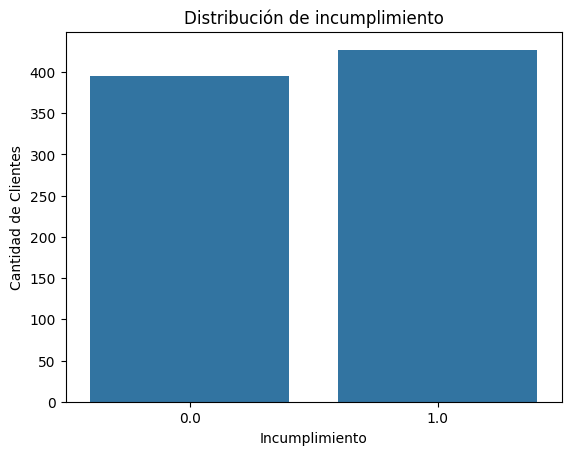

In [37]:
sns.countplot(x='incumplimiento', data=df)
plt.xlabel("Incumplimiento") 
plt.ylabel("Cantidad de Clientes")
plt.title("Distribución de incumplimiento")  
plt.show()

"I will need to apply get_dummies to these columns."



In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 905
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   incumplimiento               822 non-null    float64
 1   tipo_de_cuenta               822 non-null    object 
 2   genero                       822 non-null    object 
 3   edad_del_cliente             822 non-null    int32  
 4   co_solicitantes              822 non-null    int64  
 5   dependientes                 822 non-null    int64  
 6   monto_del_prestamo           822 non-null    float64
 7   ubicacion_de_sucursal        822 non-null    object 
 8   nivel_de_producto            822 non-null    object 
 9   es_sostenedor_principal      822 non-null    bool   
 10  grupo_de_puntaje_crediticio  205 non-null    object 
 11  area_residencial             822 non-null    object 
 12  estado_actual_de_la_cuenta   822 non-null    object 
 13  tiene_cuenta_conjunt

In [39]:
df.head()

,incumplimiento,tipo_de_cuenta,genero,edad_del_cliente,co_solicitantes,dependientes,monto_del_prestamo,ubicacion_de_sucursal,nivel_de_producto,es_sostenedor_principal,grupo_de_puntaje_crediticio,area_residencial,estado_actual_de_la_cuenta,tiene_cuenta_conjunta,residencial_Rural,residencial_Suburbana,residencial_Urbana
0,1.0,3,male,26,1,0,7.2500,Suburbana,Third,True,NaN,Urbana,no,0,0.0,0.0,1.0
1,1.0,3,female,27,1,0,71.2833,Central,First,False,C,Urbana,yes,0,0.0,0.0,1.0
2,1.0,1,female,48,0,0,7.9250,Suburbana,Third,False,NaN,Rural,yes,1,1.0,0.0,0.0
3,1.0,3,female,25,1,0,53.1000,Suburbana,First,False,C,Urbana,yes,0,0.0,0.0,1.0
4,0.0,1,male,41,0,0,8.0500,Suburbana,Third,True,NaN,Suburbana,no,1,0.0,1.0,0.0


"Gender, branch location, product level, score group, and residential area are categorical variables and need to be encoded using get_dummies."



In [40]:
df["tiene_cuenta_conjunta"] = df["tiene_cuenta_conjunta"].astype(int)
df["tipo_de_cuenta"] = df["tipo_de_cuenta"].astype(int)

In [41]:
df['es_sostenedor_principal'] = df['es_sostenedor_principal'].replace({True: 1, False: 0})

In [42]:
df["cuenta_activa"] = df['estado_actual_de_la_cuenta'].replace({"yes": 1, "no": 0})

In [43]:
df.drop(columns="estado_actual_de_la_cuenta", inplace=True)

In [44]:
df = pd.get_dummies(df, columns=[ "genero", "ubicacion_de_sucursal", "nivel_de_producto", "grupo_de_puntaje_crediticio", "area_residencial"], dtype=float)

In [45]:
df.dropna(inplace=True)

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X = df.drop('incumplimiento', axis=1)
y = df['incumplimiento']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para las importancias de las características
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Seleccionar las características más importantes (por ejemplo, las 10 más importantes)
top_features = feature_importance_df['Feature'][:10].tolist()

print("Top 10 features:", top_features)

Top 10 features: ['edad_del_cliente', 'monto_del_prestamo', 'residencial_Urbana', 'tipo_de_cuenta', 'co_solicitantes', 'area_residencial_Urbana', 'dependientes', 'cuenta_activa', 'tiene_cuenta_conjunta', 'ubicacion_de_sucursal_Central']


C:\Users\cvsob\AppData\Local\Temp\ipykernel_8372\2657984394.py:25: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_features = feature_importance_df['Feature'][:10].tolist()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


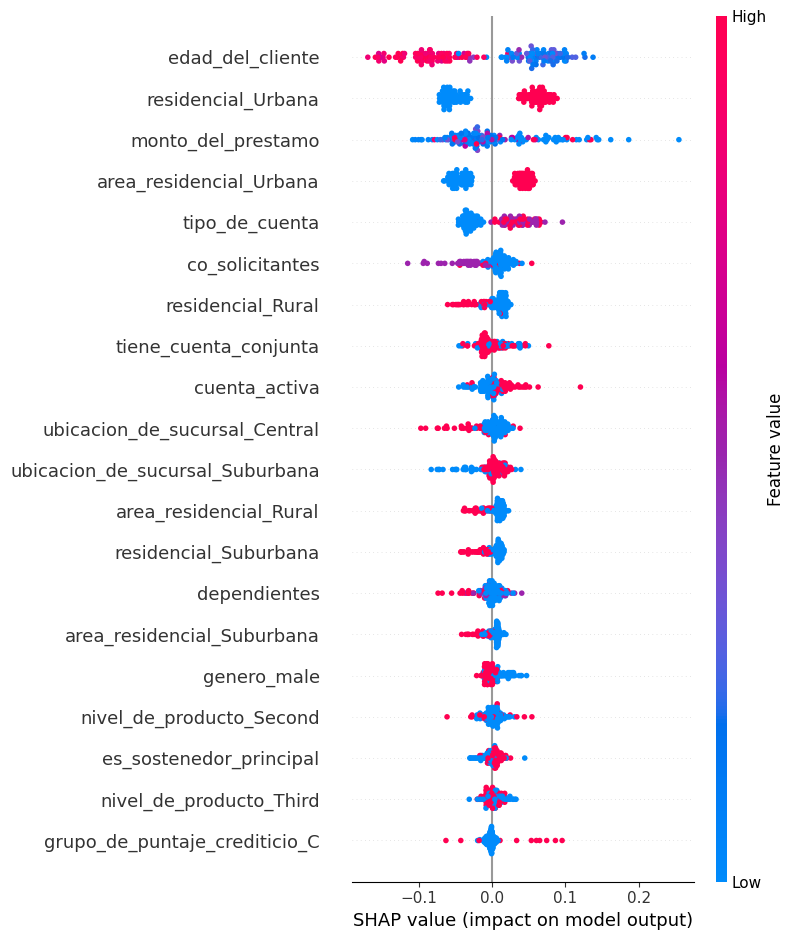

In [47]:
import shap

# Inicializar el explainer de SHAP
explainer = shap.TreeExplainer(rf)

# Calcular los SHAP values para todas las muestras en el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Visualizar el primer prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

# Visualizar el resumen para todo el conjunto de prueba
shap.summary_plot(shap_values[1], X_test)

In [48]:
df_modelos = df[["incumplimiento", 'edad_del_cliente', 'monto_del_prestamo', 'residencial_Urbana', 'tipo_de_cuenta', 'co_solicitantes', 'area_residencial_Urbana', 'dependientes', 'cuenta_activa', 'tiene_cuenta_conjunta', 'ubicacion_de_sucursal_Central']]

In [49]:
X = df_modelos.drop("incumplimiento", axis=1)  # DataFrame con características
y = df_modelos['incumplimiento']  # Serie con etiquetas

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=31415)

Puntuación de validación cruzada: [0.66257669 0.66871166 0.72839506 0.7345679  0.67901235]
Precisión en entrenamiento = 0.7852112676056338
Precisión en pruebas = 0.7090163934426229


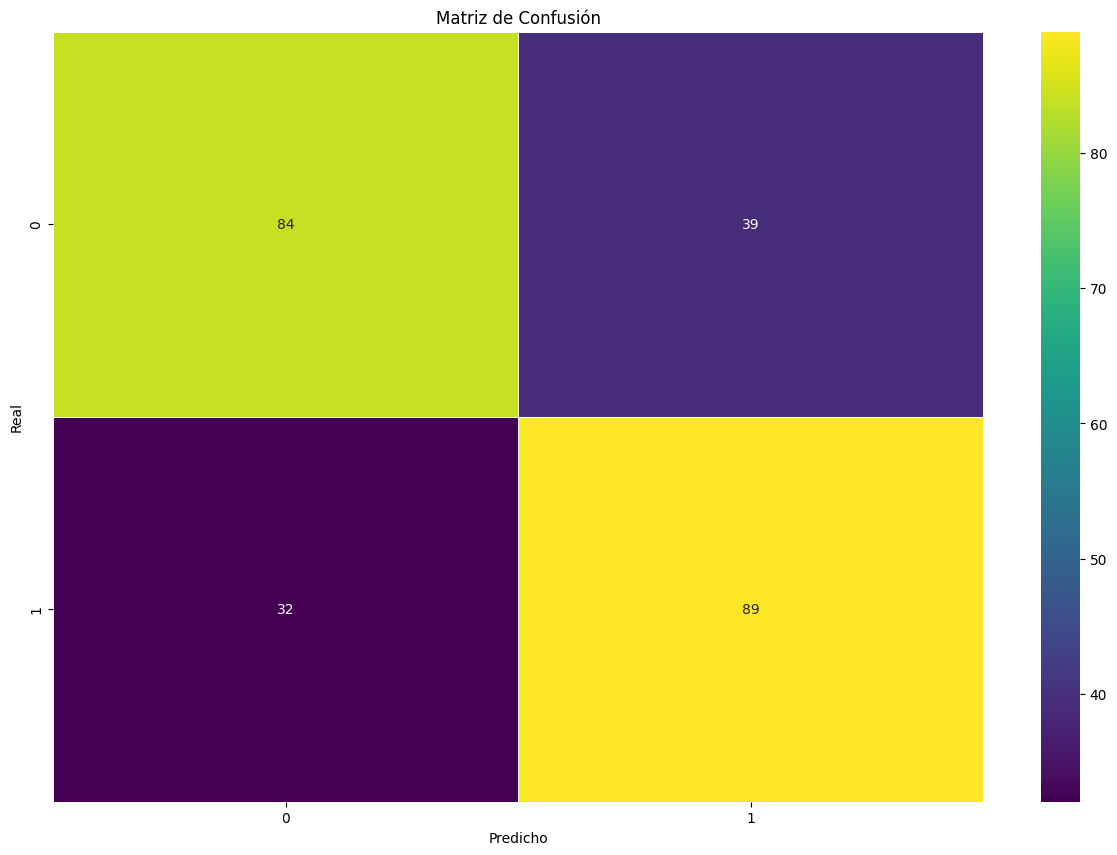

In [52]:
# Crear el modelo
decision_tree_model = DecisionTreeClassifier(criterion="entropy", random_state=2,
max_depth=5)
decision_tree_model.fit(X_train, y_train)
# Validación cruzada
score = cross_val_score(decision_tree_model, X, y, cv=5)
print('Puntuación de validación cruzada:', score)
# Precisión en entrenamiento
dt_train_accuracy = decision_tree_model.score(X_train, y_train)
print("Precisión en entrenamiento =", dt_train_accuracy)
# Precisión en pruebas
dt_test_accuracy = decision_tree_model.score(X_test, y_test)
print("Precisión en pruebas =", dt_test_accuracy)
# Matriz de confusión
y_pred = decision_tree_model.predict(X_test)
y_true = y_test
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_true, y_pred)
# Visualización de la matriz de confusión
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm_dt, annot=True, linewidth=0.5, fmt=".0f", cmap='viridis', ax=ax)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title('Matriz de Confusión')
plt.show()

The interpretation of this matrix in the context of a binary classification problem (two classes) is as follows:

True Positives (TP): 84 cases where the model correctly predicted the positive class.

False Positives (FP): 39 cases where the model incorrectly predicted the positive class.

False Negatives (FN): 32 cases where the model incorrectly predicted the negative class.

True Negatives (TN): 89 cases where the model correctly predicted the negative class.

In [53]:
# Calculating metrics manually using the confusion matrix
tp, fn, fp, tn = cm_dt.ravel()

# Metrics calculation
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Handling the case where tp + fp is 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0     # Handling the case where tp + fn is 0

In [54]:
print(accuracy) #aproximadamente el 70.9% de las predicciones del modelo son correctas.

0.7090163934426229


In [55]:
print(precision) #aproximadamente el 72.4% de las instancias predichas como positivas por el modelo son realmente positivas.

0.7241379310344828


In [56]:
print(recall)  # aproximadamente el 68.3% de las instancias positivas reales fueron identificadas correctamente por el modelo.

0.6829268292682927


In [59]:
from IPython.display import Image  
from six import StringIO
# from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 
import graphviz
import os
os.environ["PATH"] += os.pathsep + r'C:\ProgramData\Graphviz\bin'

features = list(df_modelos.columns[1:])
features

['edad_del_cliente',
 'monto_del_prestamo',
 'residencial_Urbana',
 'tipo_de_cuenta',
 'co_solicitantes',
 'area_residencial_Urbana',
 'dependientes',
 'cuenta_activa',
 'tiene_cuenta_conjunta',
 'ubicacion_de_sucursal_Central']

In [60]:
dot_data = StringIO()  
export_graphviz(decision_tree_model, out_file=dot_data,feature_names=features,filled=True,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_png('grafo.dot')

In [61]:
df_modelos.incumplimiento.value_counts()

1.0    419
0.0    393
Name: incumplimiento, dtype: int64

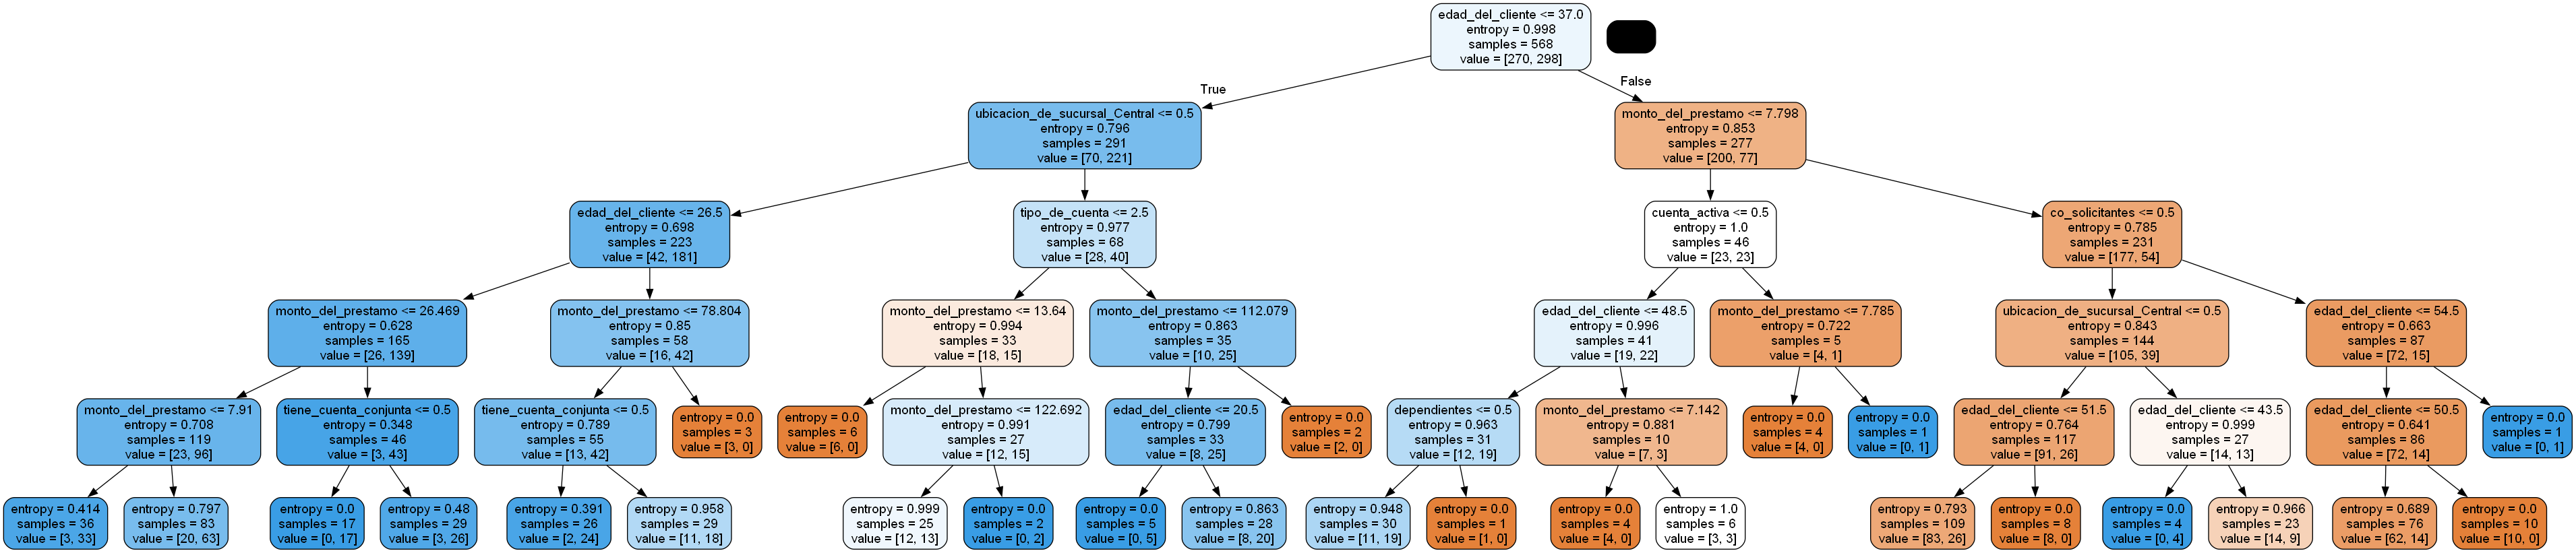

In [62]:
Image(graph[0].create_png())  

Logistic Regression Model"



In [63]:
import statsmodels.api as sm

In [64]:
print(y_train.dtypes)

float64


In [65]:
print(X_train.dtypes)

edad_del_cliente                   int32
monto_del_prestamo               float64
residencial_Urbana               float64
tipo_de_cuenta                     int32
co_solicitantes                    int64
area_residencial_Urbana          float64
dependientes                       int64
cuenta_activa                      int64
tiene_cuenta_conjunta              int32
ubicacion_de_sucursal_Central    float64
dtype: object


In [67]:
logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
logit_model
result=logit_model.fit(method="bfgs", maxiter=100)  #le agrande el nro de iteraciones
stats1=result.summary()

print(stats1)

Optimization terminated successfully.
         Current function value: 0.565266
         Iterations: 51
         Function evaluations: 55
         Gradient evaluations: 55
                          MNLogit Regression Results                          
Dep. Variable:         incumplimiento   No. Observations:                  568
Model:                        MNLogit   Df Residuals:                      558
Method:                           MLE   Df Model:                            9
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                  0.1831
Time:                        17:03:52   Log-Likelihood:                -321.07
converged:                       True   LL-Null:                       -393.02
Covariance Type:            nonrobust   LLR p-value:                 1.619e-26
             incumplimiento=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------


In [68]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Accuracy: 0.7377049180327869
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       123
         1.0       0.74      0.72      0.73       121

    accuracy                           0.74       244
   macro avg       0.74      0.74      0.74       244
weighted avg       0.74      0.74      0.74       244

Confusion Matrix:


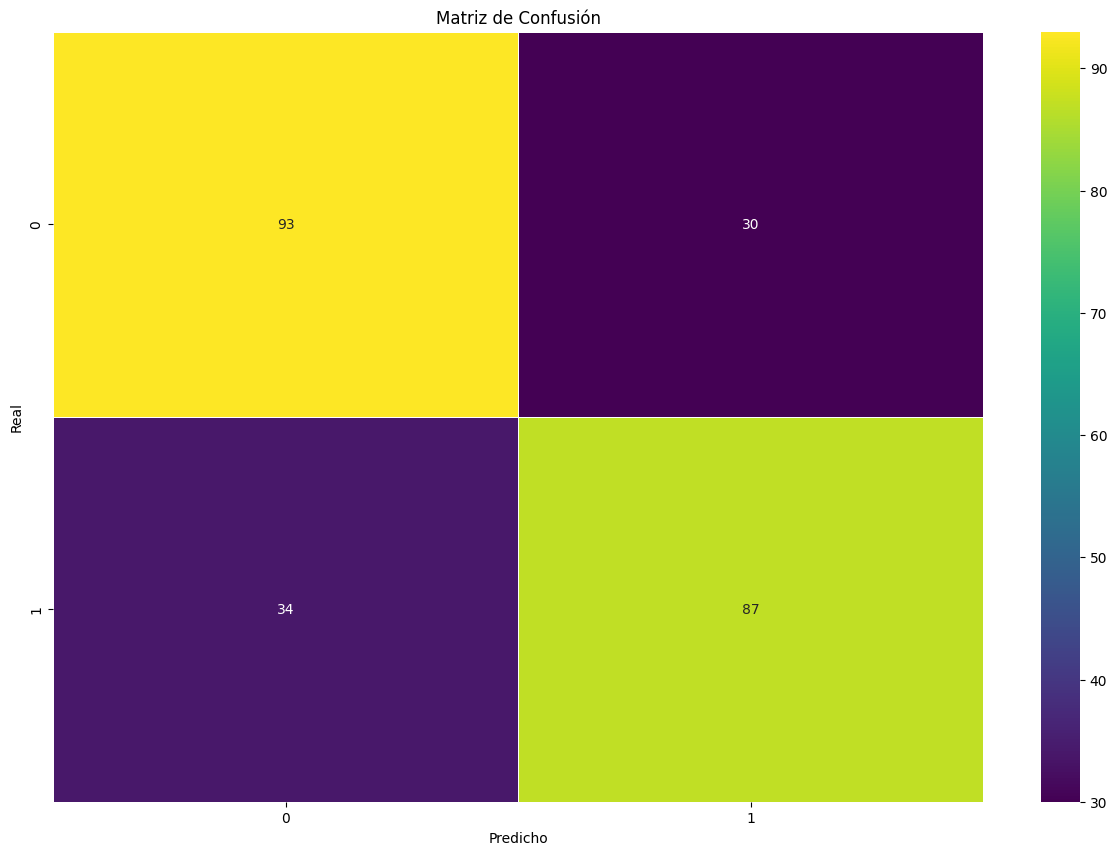

In [69]:
y_pred = result.predict(sm.add_constant(X_test))
y_pred_labels = np.argmax(y_pred.values, axis=1)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy}')

# Display other classification metrics
print(classification_report(y_test, y_pred_labels))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print('Confusion Matrix:')
# print(cm)

# Visualización de la matriz de confusión
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, linewidth=0.5, fmt=".0f", cmap='viridis', ax=ax)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title('Matriz de Confusión')
plt.show()

* Verdaderos Positivos (TP): 93
Representa el número de casos en los que el modelo predijo correctamente la clase positiva.

* Falsos Positivos (FP): 30
Representa el número de casos en los que el modelo predijo incorrectamente la clase positiva.

* Falsos Negativos (FN): 34
Representa el número de casos en los que el modelo predijo incorrectamente la clase negativa.

* Verdaderos Negativos (TN): 87
Representa el número de casos en los que el modelo predijo correctamente la clase negativa.

In [70]:
# Calculating metrics manually using the confusion matrix
tp, fn, fp, tn = cm.ravel()

# Metrics calculation
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Handling the case where tp + fp is 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0     # Handling the case where tp + fn is 0

In [523]:
print(accuracy) #alrededor del 74.6% de las predicciones son correctas.

0.7459016393442623


In [524]:
print(precision)    # aproximadamente el 73.6% de las instancias predichas como positivas por el modelo son realmente positivas

0.736


In [525]:
print(recall)   #aproximadamente el 76.0% de las instancias positivas reales fueron identificadas correctamente por el modelo.

0.7603305785123967
